Delta x = 0.01 Delta t =  5e-05 C = 0.5


/tmp/ipykernel_545/47707332.py:117: RuntimeWarning: overflow encountered in scalar add
  u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - a*(u_old[i] - u_inf)
/tmp/ipykernel_545/47707332.py:117: RuntimeWarning: invalid value encountered in scalar add
  u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - a*(u_old[i] - u_inf)


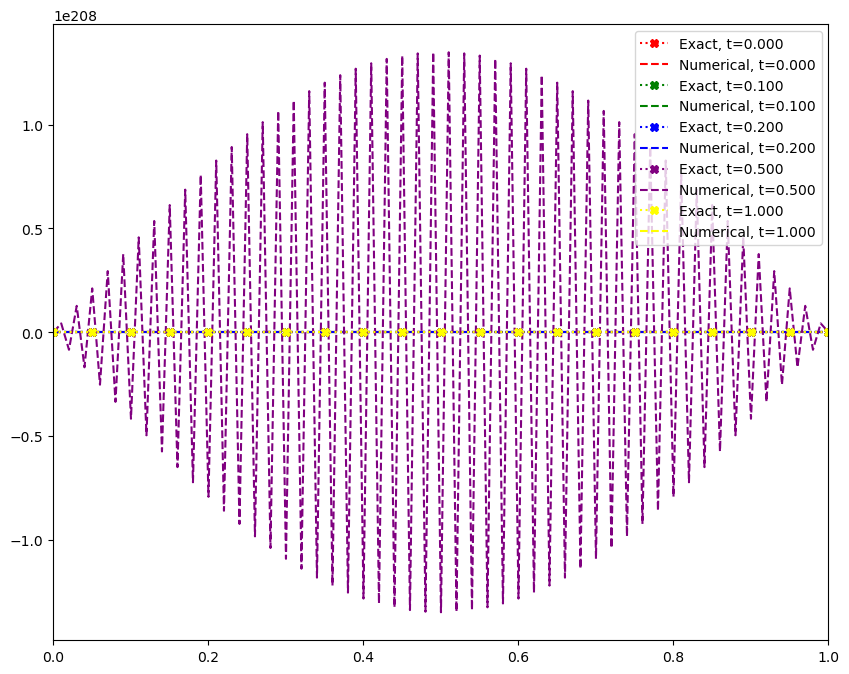

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

# Boundary conditions
b0 = 150  # u(0,t)= b0
bL = 20   # u(L,t)= bL
a = 0.05 # heat transfer coefficient
u_inf = bL # air temp

# Initial condition u(x,0)
def I(x): 
    len_x = np.size(x)
    i_x = 20 *np.ones(len_x) # For constant initial temperature of the liquid
    return i_x

# Input analytical solution found by hand
def U_exact(x,t):
    M = np.size(x)
    u_ex = np.zeros(M)  

    # our analytical solution is only for t>0. At t=0, we have our initial condition, given by the step function below.
    if t == 0:
        u_ex = np.where(x == 0, b0, bL)
        return u_ex

    for n in range(1,2000):  # use 2000 terms in the summation of the exact solution
        npi= n*np.pi
        if (n%2 == 0):
            c_n = (260)*((-1)**(n+1))/(npi)             
        else:
            c_n = (260)*((-1)**(n+1))/(npi) - 560/npi                  
        u_ex = u_ex + c_n*np.sin(npi*x)*np.exp(-1*(npi)**2*t)
        
    u_ex = u_ex + 150 - 130*x  # include 150 - 130x term in exact solution. In particular this forces U(0,t) = 150, U(1,t) = 20.
    return u_ex

def plotting(U,L):
    size_t = np.size(U,1)-1 # number of time steps
   
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    markers =['X','.','+','o']

    colours = ['r','g','b','purple','yellow'] # make comparison easy
    colour_pos = 0;

    N_dots = 20
    x_dots = np.linspace(0, L, N_dots+1) # spatial points to plot exact solution at

    # some arbitarily chosen time points to compare at
    for plot_pos in [0, int(size_t/10),int(size_t/5), int(size_t/2), int(size_t)]:
        # exact solution
        U_tplot = U_exact(x_dots,t[plot_pos]) 
        label = "Exact, t=" + "%0.3f" % (t[plot_pos],)
        ax.plot(x_dots,U_tplot,linestyle = ':',color = colours[colour_pos],marker = markers[0], label=label)

        # numerical solution
        label = "Numerical, t=" + "%0.3f" % (t[plot_pos],)
        ax.plot(x,U[:,plot_pos],color = colours[colour_pos],ls='--', label=label)
        colour_pos = colour_pos + 1
    
    plt.xlim(0,L) # zoom in on area of interest
    ax.legend() # turn on legend 
    plt.show()

# Set parameters

Nt_gaps = 20000    # number of timesteps
T = 1              # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step

Nx_spaces = 100;   # number of spaces in x
L = 1; # Length of the can, 1 for now, will need to be changed but this will affect the exact solution as well
Nx_points = Nx_spaces + 1 
x = np.linspace(0, L, Nx_points)    # mesh points in space

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt/(dx**2)

print("Delta x =", dx, "Delta t = ", dt, "C =", C)

# Initialize output

# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points,Nt_points))

# The initial condition
U[:,0]=I(x)

# enforce the boundary condition
U[0,0]  = b0 
U[-1,0] = bL

'''
 This script finds a numerical approximation for the solution to
 the following 1D heat equation:
   u_t = u_xx  for  x in (0,1),  t in (0,T),
   u(x,t=0) = 20
   u(x=0,t) = 150;  u(x=1,t) = 20,
 using a forward Euler scheme.
''' 
u_old = I(x)        # old/current values
u = np.zeros(Nx_points) # new values

for n in range(1, Nt_points):
    # set Dirichlet boundary points
    u[0]  = b0   
    u[-1] = bL
    
    # apply forward Euler on the internal points
    for i in range(1, Nx_points-1):
        u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - a*(u_old[i] - u_inf)
 
    # update u_old before next step
    u_old[:]= u
    # copy into full storage
    U[:,n] = u

# plot snapshots of the solution
plotting(U, L)

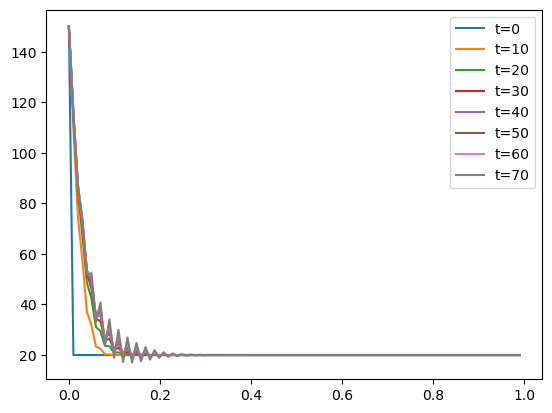

In [21]:
for t in range(0, 80, 10):
    plt.plot(np.arange(0, 1, 1/Nx_points), U[:, t], label = f"{t=}")

plt.legend()

i want to do backward euler with a sink term

In [22]:
# Data structures for the linear system
A = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

for i in range(1, Nx_points-1):
    A[i,i-1] = -C
    A[i,i+1] = -C
    A[i,i] = 1 + 2*C
    
# implement the (constant-in-time) Dirichlet conditions (i.e. U(0, t+dt) = U(0, t+dt), same at x=1)
A[0,0] = 1
A[Nx_points-1,Nx_points-1] = 1

# Set initial conditions
u_old[0] = 150
u_old[1:] = 20*np.ones(Nx_points-1)

# initialise matrices for storing solutions
U[:,0] = u_old[:]

# This vector is the integral of the solution to the diffusion equation, the average temperature
avtemp = np.zeros(Nt_points)

# Stores the integral found using the python comand
avtemp_test = np.zeros(Nt_points)

# do timestepping 
for n in range(1, Nt_points):
    b = u_old

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A,b) 
    u_new[1:Nx_points-1] -= a*(u_old[1:Nx_points-1] - u_inf) # I don't want to subtract this from the end points
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new

    # Integrate using the trapezoidal rule
    avtemp[n] = np.sum(dx * 0.5 * (u_new[:-1] + u_new[1:]))

    avtemp_test[n] = np.trapz(u_new,x)

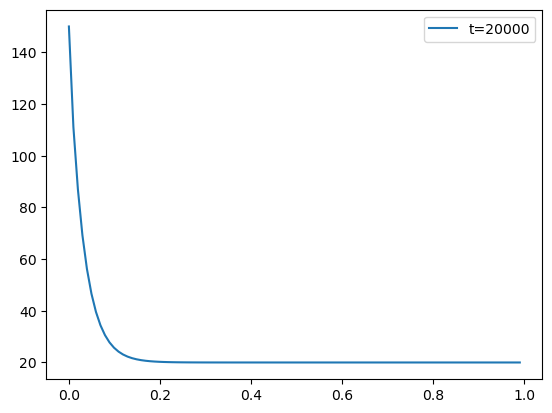

In [23]:
#for t in range(1, 1000, 100):
t = Nt_points - 1
plt.plot(np.arange(0,1,1/Nx_points), U[:, t], label = f"{t=}")

plt.legend()
plt.show()

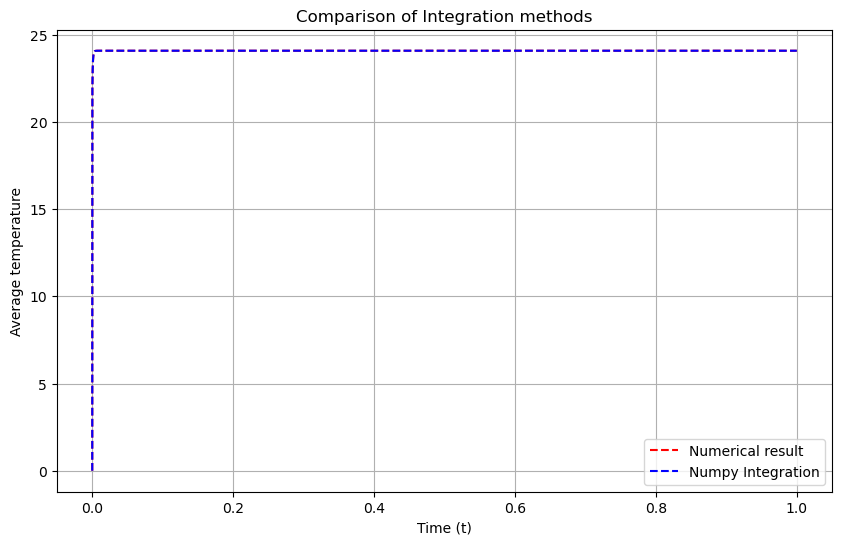

In [24]:
t = np.linspace(0.,T,Nt_points)  # times at each time step

# Plot the comparison between trapezoidal integration from the formula and numpy's trapz
plt.figure(figsize=(10, 6))
plt.plot(t, avtemp, label='Numerical result', linestyle='--', color='r')
plt.plot(t, avtemp_test, label='Numpy Integration', linestyle='--', color='b')
plt.xlabel('Time (t)')
plt.ylabel('Average temperature')
plt.title('Comparison of Integration methods')
plt.legend()
plt.grid(True)
plt.show()